# Imports

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
keras = tf.keras

In [ ]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)

def trend(time, slope=0):
    return slope * time


def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))


def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)


def white_noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

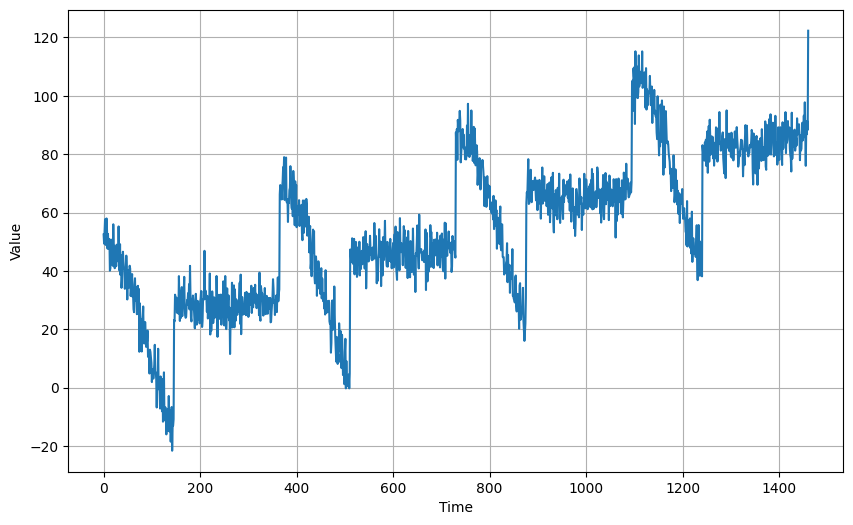

In [ ]:
time = np.arange(4 * 365 + 1)

slope = 0.05
baseline = 10
amplitude = 40
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

noise_level = 5
noise = white_noise(time, noise_level, seed=42)

series += noise

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

# Forecasting with Machine Learning

In [ ]:
def window_dataset(series, window_size, batch_size=32,
                   shuffle_buffer=1000):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [ ]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

# Linear Model

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size)
valid_set = window_dataset(x_valid, window_size)

model = keras.models.Sequential([
  keras.layers.Dense(1, input_shape=[window_size])
])
optimizer = keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
model.fit(train_set, epochs=100, validation_data=valid_set)

Epoch 1/100
31/31 [==============================] - 1s 23ms/step - loss: 271.6765 - mae: 272.1751 - val_loss: 746.5543 - val_mae: 747.0543
Epoch 2/100
31/31 [==============================] - 0s 7ms/step - loss: 404.7178 - mae: 405.2178 - val_loss: 479.4505 - val_mae: 479.9505
Epoch 3/100
31/31 [==============================] - 0s 6ms/step - loss: 350.0941 - mae: 350.5940 - val_loss: 412.9981 - val_mae: 413.4981
Epoch 4/100
31/31 [==============================] - 0s 6ms/step - loss: 241.4087 - mae: 241.9082 - val_loss: 911.6705 - val_mae: 912.1705
Epoch 5/100
31/31 [==============================] - 0s 6ms/step - loss: 353.1724 - mae: 353.6721 - val_loss: 305.2269 - val_mae: 305.7269
Epoch 6/100
31/31 [==============================] - 0s 8ms/step - loss: 655.7154 - mae: 656.2153 - val_loss: 3294.6240 - val_mae: 3295.1240
Epoch 7/100
31/31 [==============================] - 0s 6ms/step - loss: 695.1726 - mae: 695.6725 - val_loss: 1670.6510 - val_mae: 1671.1510
Epoch 8/100
31/31 [===

Using callback

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size)

model = keras.models.Sequential([
  keras.layers.Dense(1, input_shape=[window_size])
])

lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-6 * 10**(epoch / 30))
optimizer = keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
31/31 [==============================] - 2s 4ms/step - loss: 33.9869 - mae: 34.4855 - lr: 1.0000e-06
Epoch 2/100
31/31 [==============================] - 0s 3ms/step - loss: 19.2611 - mae: 19.7568 - lr: 1.0798e-06
Epoch 3/100
31/31 [==============================] - 0s 2ms/step - loss: 8.7361 - mae: 9.2251 - lr: 1.1659e-06
Epoch 4/100
31/31 [==============================] - 0s 2ms/step - loss: 7.7265 - mae: 8.2155 - lr: 1.2589e-06
Epoch 5/100
31/31 [==============================] - 0s 2ms/step - loss: 7.6992 - mae: 8.1859 - lr: 1.3594e-06
Epoch 6/100
31/31 [==============================] - 0s 3ms/step - loss: 7.6884 - mae: 8.1750 - lr: 1.4678e-06
Epoch 7/100
31/31 [==============================] - 0s 2ms/step - loss: 7.6804 - mae: 8.1683 - lr: 1.5849e-06
Epoch 8/100
31/31 [==============================] - 0s 3ms/step - loss: 7.6611 - mae: 8.1474 - lr: 1.7113e-06
Epoch 9/100
31/31 [==============================] - 0s 2ms/step - loss: 7.6603 - mae: 8.1462 - lr: 1.8478e-

(1e-06, 0.001, 0.0, 20.0)

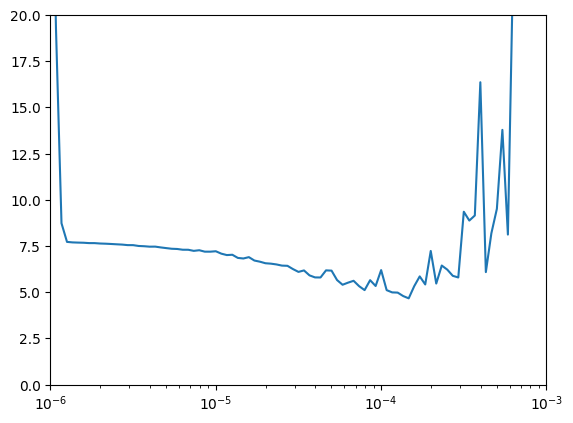

In [ ]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-6, 1e-3, 0, 20])

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size)
valid_set = window_dataset(x_valid, window_size)

model = keras.models.Sequential([
  keras.layers.Dense(1, input_shape=[window_size])
])
optimizer = keras.optimizers.SGD(learning_rate=1e-5, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
early_stopping = keras.callbacks.EarlyStopping(patience=10)
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping])

Epoch 1/500
31/31 [==============================] - 3s 15ms/step - loss: 17.2800 - mae: 17.7759 - val_loss: 10.3091 - val_mae: 10.7996
Epoch 2/500
31/31 [==============================] - 0s 7ms/step - loss: 8.8833 - mae: 9.3677 - val_loss: 9.0026 - val_mae: 9.4948
Epoch 3/500
31/31 [==============================] - 0s 8ms/step - loss: 8.7108 - mae: 9.1993 - val_loss: 8.8294 - val_mae: 9.3135
Epoch 4/500
31/31 [==============================] - 0s 8ms/step - loss: 8.5734 - mae: 9.0594 - val_loss: 8.6249 - val_mae: 9.1040
Epoch 5/500
31/31 [==============================] - 0s 7ms/step - loss: 8.4175 - mae: 8.9032 - val_loss: 8.4241 - val_mae: 8.9092
Epoch 6/500
31/31 [==============================] - 0s 8ms/step - loss: 8.2867 - mae: 8.7704 - val_loss: 8.5981 - val_mae: 9.0878
Epoch 7/500
31/31 [==============================] - 0s 8ms/step - loss: 8.2449 - mae: 8.7308 - val_loss: 8.4314 - val_mae: 8.9184
Epoch 8/500
31/31 [==============================] - 0s 6ms/step - loss: 8.193

In [ ]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [ ]:
lin_forecast = model_forecast(model, series[split_time - window_size:-1], window_size)[:, 0]

15/15 [==============================] - 7s 12ms/step


In [ ]:
lin_forecast.shape

(461,)

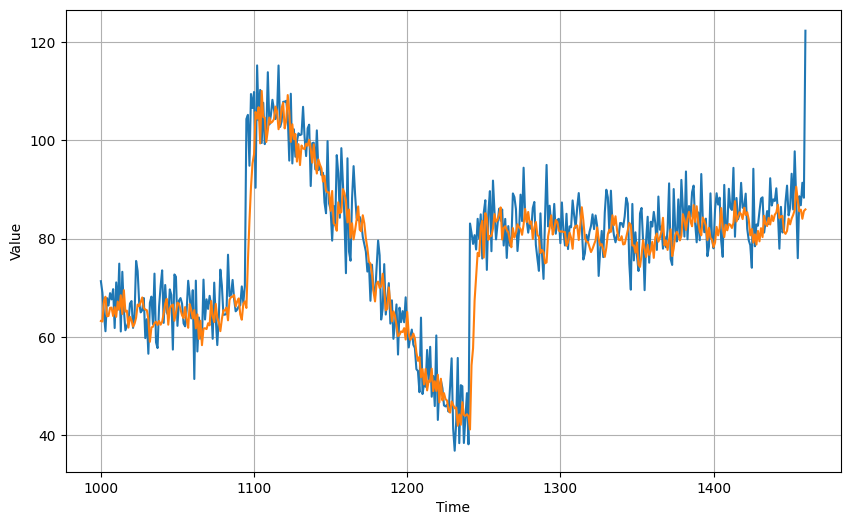

In [ ]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, lin_forecast)

In [ ]:
keras.metrics.mean_absolute_error(x_valid, lin_forecast).numpy()

5.032334

# Dense Model Forecasting

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size)
valid_set = window_dataset(x_valid, window_size)

model = keras.models.Sequential([
  keras.layers.Dense(10, activation="relu", input_shape=[window_size]),
  keras.layers.Dense(10, activation="relu"),
  keras.layers.Dense(1)
])

optimizer = keras.optimizers.SGD(learning_rate=1e-5, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
early_stopping = keras.callbacks.EarlyStopping(patience=10)
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping])

Epoch 1/500
31/31 [==============================] - 1s 12ms/step - loss: 45.6657 - mae: 46.1657 - val_loss: 73.3935 - val_mae: 73.8935
Epoch 2/500
31/31 [==============================] - 0s 8ms/step - loss: 30.8202 - mae: 31.3184 - val_loss: 32.1396 - val_mae: 32.6396
Epoch 3/500
31/31 [==============================] - 0s 8ms/step - loss: 9.2400 - mae: 9.7288 - val_loss: 6.4349 - val_mae: 6.9200
Epoch 4/500
31/31 [==============================] - 0s 8ms/step - loss: 6.8312 - mae: 7.3103 - val_loss: 6.3276 - val_mae: 6.8119
Epoch 5/500
31/31 [==============================] - 0s 8ms/step - loss: 6.6601 - mae: 7.1418 - val_loss: 6.2173 - val_mae: 6.7034
Epoch 6/500
31/31 [==============================] - 0s 6ms/step - loss: 6.5483 - mae: 7.0274 - val_loss: 6.4014 - val_mae: 6.8793
Epoch 7/500
31/31 [==============================] - 0s 8ms/step - loss: 6.4667 - mae: 6.9436 - val_loss: 6.1131 - val_mae: 6.5959
Epoch 8/500
31/31 [==============================] - 0s 6ms/step - loss: 6

In [ ]:
dense_forecast = model_forecast(
    model,
    series[split_time - window_size:-1],
    window_size)[:, 0]

15/15 [==============================] - 56s 7ms/step


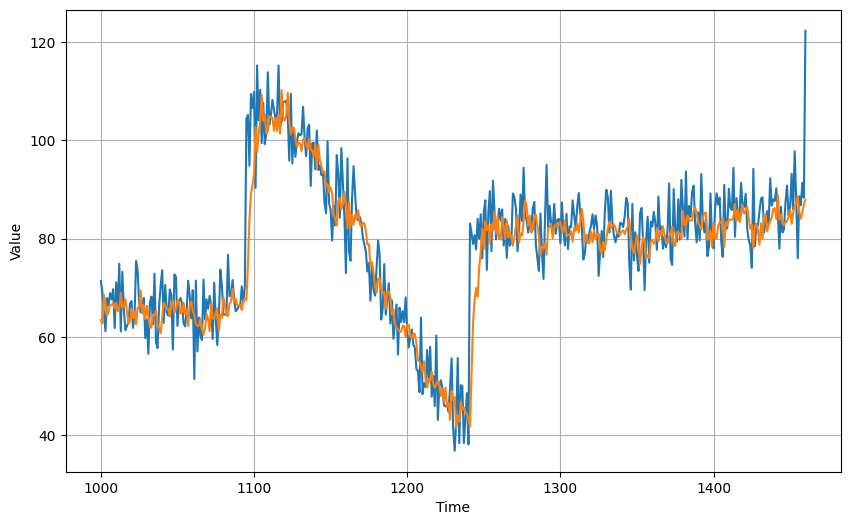

In [ ]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, dense_forecast)

In [ ]:
keras.metrics.mean_absolute_error(x_valid, dense_forecast).numpy()

4.922474